# DQN 
## Cartpole

Fabrice Mulotti


In [1]:
import numpy as np
import gymnasium as gym
from collections import deque
import random

import tensorflow as tf
print(tf.__version__)

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.optimizers import Adam # si vous utilisz un mac M1/M2 utiliser legacy.optimizers

from IPython.display import display, clear_output
import matplotlib.pyplot as plt

%matplotlib inline

2024-10-28 21:02:25.539301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730163745.612868    9832 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730163745.633650    9832 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 21:02:25.697569: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.0


Si vous avez erreur TypeError: unhashable type: 'list', c'est que votre version de python est trop ancienne (conseillee 3.11)

In [2]:
# tf.compat.v1.disable_eager_execution()

---
## Définition de l'environnement

In [3]:
ENV_NAME = 'CartPole-v1'

env = gym.make(ENV_NAME)
np.random.seed(100)
env.reset(seed=100)
nb_actions = env.action_space.n # Nombre d'action
nb_obs = env.observation_space.shape[0] # nombre de paramètre pour décrire l'environnement
print(f"Nombre d actions : {nb_actions}, Dimension de l env : {nb_obs}")

Nombre d actions : 2, Dimension de l env : 4


# Remarques sur l'environnement

2 actions possibles :<br>
    poussée vers la gauche<br>
    poussée vers la droite<br>
    
Observation :<br>
    Valeurs **continues** !

## Fonctions utiles

In [4]:
# Classe pour notre algorithme DQN
class DQN:
    def __init__(self, obs_size, action_size, gamma, learning_rate):
        # Objet : initialisation de la classe
        # Paramètres en entrée
        #     Nombre de paramètre pour décrire l'état
        #     Nombre d'actions
        #.    Paramètre gamma : dépréciation futur
        #     learning rate
        
        # dimension des états
        self.obs_size = obs_size
        
        # nombre d'actions
        self.action_size = action_size
        
        # gamma : dépréciation du futur
        self.gamma = gamma
        
        # learning rate
        self.learning_rate = learning_rate
        
        # autres paramètres
        self.update_freq = 100 # fréquence de copie des poids (1000)
        
        # autres structures
        self.replay_buffer = deque(maxlen=100000) # enregistrements des résultats
        
        # Modèle de réseaux de neurones
        self.main_network = self.build_model(16,8)
        self.target_network = self.build_model(16,8)
        # recopie des poids pour avoir des réseaux à l'identique
        self.target_network.set_weights(self.main_network.get_weights())
        
        self.debug = 0
        
    def build_model(self,layer1,layer2):
        # input : size of the 2 layers
        # output : model of neural network
        model = Sequential()
        model.add(Input(shape=(self.obs_size,)))
        model.add(Dense(layer1,activation='relu'))
        model.add(Dense(layer2,activation='relu'))
        model.add(Dense(self.action_size))
        model.add(Activation('linear'))
        model.compile(loss='mse',optimizer=Adam(learning_rate=self.learning_rate),jit_compile=True)
        return model

    def store_transition(self,state,action,reward,next_state,done):
        # input : 
        # output : nothing
        self.replay_buffer.append((state,action,reward,next_state,done))
             
    def policy(self, state, epsilon):
        # Policy: return action based on the epsilon-greedy policy
        if np.random.rand() < epsilon:
            # Exploration: choose a random action
            action = np.random.randint(self.action_size)
        else:
            # Exploitation: choose the action with the highest Q-value
            state = np.array(state).reshape(1, -1)  # Reshape to match model input shape
            q_values = self.main_network.predict(state, verbose=0)
            action = np.argmax(q_values[0])  # Choose the action with the highest Q-value

        return action

    

    @tf.function
    def _train_main(self, states, Q_values):
        self.main_network.fit(states, Q_values, epochs=1, verbose=0)

    def train_model(self,batch_size):
        self.debug=0
        # sélection d'un échantillon
        minibatch = random.sample(self.replay_buffer,batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*minibatch))

        states=states.squeeze()
        next_states=next_states.squeeze()
        
        # On récupere les Q values des états rencontrés
        Q_values = self.main_network.predict(states,verbose = 0)
        
        Updates = rewards + self.gamma * np.amax(self.target_network.predict(next_states,verbose=0),axis=1) * (1-dones)
        
        Q_values[ np.arange(len(Updates)),actions] = Updates

        # ############################################################################
        # Votre code : entrainement
        # Astuce : vous pouvez mettre l'entrainement dans une fonction avec un décorateur tf.function
        self.main_network.fit(states, Q_values, epochs=1, verbose=0, batch_size=batch_size)
    
    def update_weights(self):
        self.target_network.set_weights(self.main_network.get_weights())

In [5]:
# transformation des données pour compatabilité avec l'alimentation du réseau de neurones (1,s)`
def trans_state(s):
    return  np.reshape(s, [1, nb_obs])

In [6]:
num_episodes = 2000
batch_size = 16 # K
gamma=0.98

# variation du epsilon de notre politique e-greedy
epsilon_max=1.00
epsilon_min=0.05
epsilon_decay=0.992 

learning_rate=0.0005 # 0.001

In [7]:
dqn = DQN(env.observation_space.shape[0],env.action_space.n,gamma,learning_rate)

2024-10-28 21:02:33.441384: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Episode: 431, Return: 175.0, Epsilon: 0.05, End: False
Episode: 432, Return: 259.0, Epsilon: 0.05, End: False
Episode: 433, Return: 237.0, Epsilon: 0.05, End: False
Episode: 434, Return: 236.0, Epsilon: 0.05, End: False
Episode: 435, Return: 235.0, Epsilon: 0.05, End: False
Episode: 436, Return: 216.0, Epsilon: 0.05, End: False
Episode: 437, Return: 223.0, Epsilon: 0.05, End: False
Episode: 438, Return: 225.0, Epsilon: 0.05, End: False



KeyboardInterrupt



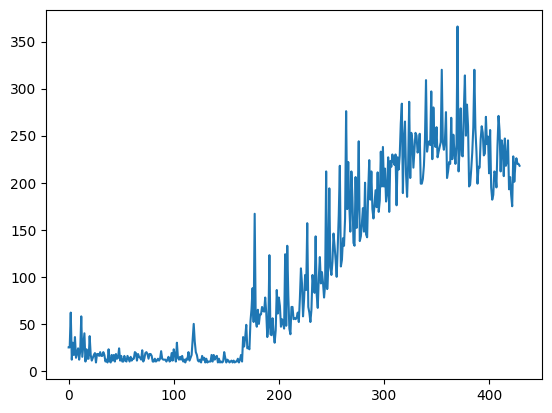

In [8]:
time_step = 0  # total movement count
histoReturn = []  # for reward history plotting
epsilon = epsilon_max
checkpoint_path = "cartpole-save.weights.h5"

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(num_episodes):
    # Total reward for each cycle
    Return = 0
    
    # Reset environment and convert initial state
    state = trans_state(env.reset()[0])
    done = False
    truncated = False

    while not (done or truncated):
        time_step += 1

        # Copy weights from main network to target network at specified intervals
        if time_step % dqn.update_freq == 0:
            dqn.update_weights()

        # Choose an action according to the epsilon-greedy policy
        action = dqn.policy(state, epsilon)

        # Play the selected action and receive feedback
        next_state, reward, done, truncated, _ = env.step(action)
        next_state = trans_state(next_state)  # Convert next state to suitable format
        
        if truncated:
            done = True

        # Store the experience in replay memory
        dqn.store_transition(state, action, reward, next_state, done)

        # Shift to the next state
        state = next_state

        # Accumulate total return
        Return += reward

        # Check if episode is done
        if done or truncated:
            # Display results of the cycle
            print(f'Episode: {i}, Return: {Return}, Epsilon: {np.round(epsilon, 2)}, End: {truncated}')
            
            # Update reward history plot every 10 episodes
            if i % 10 == 0:
                ax.clear()
                ax.plot(histoReturn)
                display(fig)
                clear_output(wait=True)

            # Decrement epsilon for exploration-exploitation tradeoff
            epsilon *= epsilon_decay
            epsilon = max(epsilon_min, epsilon)
            histoReturn.append(Return)

            # Save model weights every 50 episodes
            if i % 50 == 0:
                dqn.main_network.save_weights(checkpoint_path)
            break

        # Train the network once replay buffer has enough samples
        if len(dqn.replay_buffer) > batch_size:
            dqn.train_model(batch_size)


---
# Visualisons le résultat

In [ ]:
ENV_NAME = 'CartPole-v1'

env = gym.make(ENV_NAME,render_mode='human')
nb_actions = env.action_space.n # Nombre d'action
nb_obs = env.observation_space.shape[0] # nombre de paramètre pour décrire l'environnement


In [ ]:
# Pas besoin d'exécuter cette séquence si vous lancez le test après l'entrainement
dqn = DQN(env.observation_space.shape[0],env.action_space.n,0,0)
dqn.main_network.load_weights("cartpole-save.weights.h5")

In [ ]:
state=trans_state(env.reset()[0])
done = False
truncated=False
Gain=0
while not (done or truncated):
    action = dqn.policy(state,0)
    next_state, reward, done, truncated , _ = env.step(action)
    Gain += reward
    state=trans_state(next_state)
print(f"Gain {Gain}")